In [10]:
import copy
import os
import sys
sys.path.append('/data/hylacola/sulem/PycharmProjects/HawkesVI/')
import numpy as np
import pandas as pd
import seaborn as sns # for plot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False}) # set seaborn style
import matplotlib.pyplot as plt # for plot
from snm_hawkes_beta import SNMHawkesBeta
#from sigmoid_hawkes import SigmoidHawkesBeta
#from sigmoid_histo import SigmoidHawkesHisto
from models.nlmodel import NonlinHawkesBasis, LinkFunction
from scipy.stats import gamma, norm
from scipy.stats import beta
from time import time
from scipy.special import expit
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
from utils import nb_excursions, precompute_basis_values, NpEncoder, plot_functions_norms, f_norm_histo, nd_block_diag
from utils import mask_from_graph, exp_f_norm_histo, exp_nu_norm
from scipy import optimize
import scipy
from utils import nb_excursions, gq_points_weights
#import stan
import json
import pickle
from skfda.representation.basis import Fourier
import arviz as az
import os
import itertools

In [28]:
save_dir = '/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/results/synthetic_data/'

config = []
m_probas = []
mean_estimator = []
cov_estimator = []
elbo = []
est_norms = []
true_norms = []
list_links = []
sel_models = []

# Excitation scenario
list_files = ["01_30_10:02:58_relu_D10_T_300_exc", "01_30_13:01:46_softplus_D10_T_300_exc", "01_30_16:11:55_unknown_sigmoid_D10_T_300_exc"]
scen = 'exc'
# list_files = ["01_30_11:31:33_relu_D10_T_300_inh", "01_30_14:25:59_softplus_D10_T_300_inh", "01_30_17:39:58_unknown_sigmoid_D10_T_300_inh"]
# scen = 'inh'
for j, file in enumerate(list_files):

    with open(save_dir + file + f'/config.json', 'r') as f:
        config.append( json.load(f) )
    with open(save_dir + file + f'/selected_model.json', 'r') as f:
        sel_models.append( json.load(f) )
    with open(save_dir + file + f'/est_norms.json', 'r') as f:
        est_norms.append( json.load(f) )
    with open(save_dir + file + f'/true_norms.json', 'r') as f:
        true_norms.append( np.array(json.load(f)) )
    with open(save_dir + file + f'/model_probas.json', 'r') as f:
        m_probas.append( json.load(f) )
    with open(save_dir + file + f'/MAP_estimates.json', 'r') as f:
        mean_nu, mean_weight, cov = json.load(f)
        mean_estimator.append( [mean_nu, mean_weight] )
        cov_estimator.append( cov)
    list_links.append(config[-1]["link"])
number_of_dimensions = config[0]["n_dim"]

config[-1]

{'n_dim': 10,
 'n_bas': 2,
 'basis_true': 'histogram',
 'graph': [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]],
 'basis_estimation': 'histogram',
 'link': 'unknown_sigmoid',
 'theta': 0.0,
 'lamda_ub': [12.41741194542335,
  13.120256704411283,
  28.367730253975864,
  27.38762050489139,
  15.244184129782631,
  25.462700978518818,
  14.339374666900142,
  18.86818804709108,
  14.029426587003705,
  22.940343029913578],
 'estimate_lamda': False,
 'eta': 10.0,
 'beta': 0.2,
 'base_activation': [5.55566785675

In [29]:
# Number of events
for i in range(len(config)):
    print("Number of events: ", config[i]["N_eve"])

Number of events:  46337
Number of events:  30710
Number of events:  36355


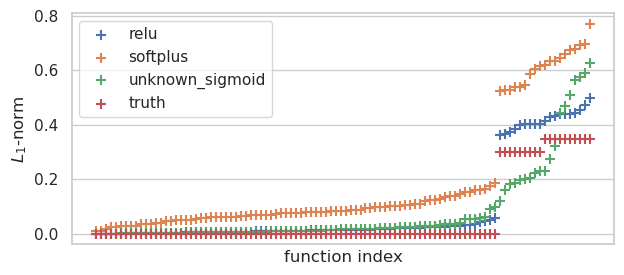

In [30]:
# Plot ordered norms for each T
threshold = np.min(true_norms[0][true_norms[0]>0])
fig, ax = plt.subplots(1,1, figsize=(7,3))
ax.set_ylabel(r"$L_1$-norm")
ax.set_xlabel("function index")
ax.set_xticks([])
for i in range(len(config)):
    norms = np.array(est_norms[i])
    t_norms = np.array(true_norms[i])
    sort_norms = np.sort(norms.reshape(-1))
    sort_true_norms = np.sort(t_norms.reshape(-1))
    ax.scatter(range(len(sort_norms)), sort_norms, marker='+', s=50, label=f"{list_links[i]}")
    if i>len(config)-2:
        ax.scatter(range(len(sort_true_norms)), sort_true_norms, marker='+', s=50, label=f"truth", color='r')
        # ax.hlines(xmin=0, xmax=len(sort_norms), y=threshold, label=r"$\eta_0$", color='r',
        #           linewidth=1)
    ax.legend()
    ax.grid()
plt.savefig(f"/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/results/figures/L1_norms_D{number_of_dimensions}D_{scen}_mispecified.pdf")

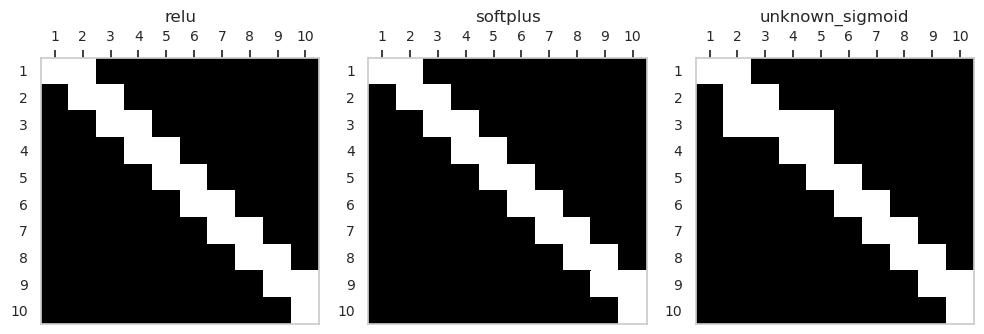

In [32]:
# Estimated graph
thresholds = [0.2, 0.2, 0.08] # excitation
#thresholds = [0.2, 0.26, 0.15] # inhibition
fig, ax = plt.subplots(1, len(config), figsize=(10,3.5))
for j in range(len(config)):
    graph = (np.array(est_norms[j]) > thresholds[j]).astype(int)
    heatmap = ax[j].pcolor(graph, cmap='Greys_r')
    node_names = range(1,number_of_dimensions+1)
    column_labels = [i for i in node_names]
    row_labels = [i for i in node_names]
    # put the major ticks at the middle of each cell
    ax[j].set_xticks(np.arange(graph.shape[0]) + 0.5, minor=False)
    ax[j].set_yticks(np.arange(graph.shape[1]) + 0.5, minor=False)
    # want a more natural, table-like display
    ax[j].invert_yaxis()
    ax[j].xaxis.tick_top()
    ax[j].set_xticklabels(row_labels, minor=False, fontsize=10)
    ax[j].set_yticklabels(column_labels, minor=False, fontsize=10)
    ax[j].set_title(f"{list_links[j]}")
    #fig.colorbar(heatmap)
plt.tight_layout()
plt.savefig(f"/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/results/figures/estimated_graph_D{number_of_dimensions}_{scen}_mispecified.pdf")
plt.show()

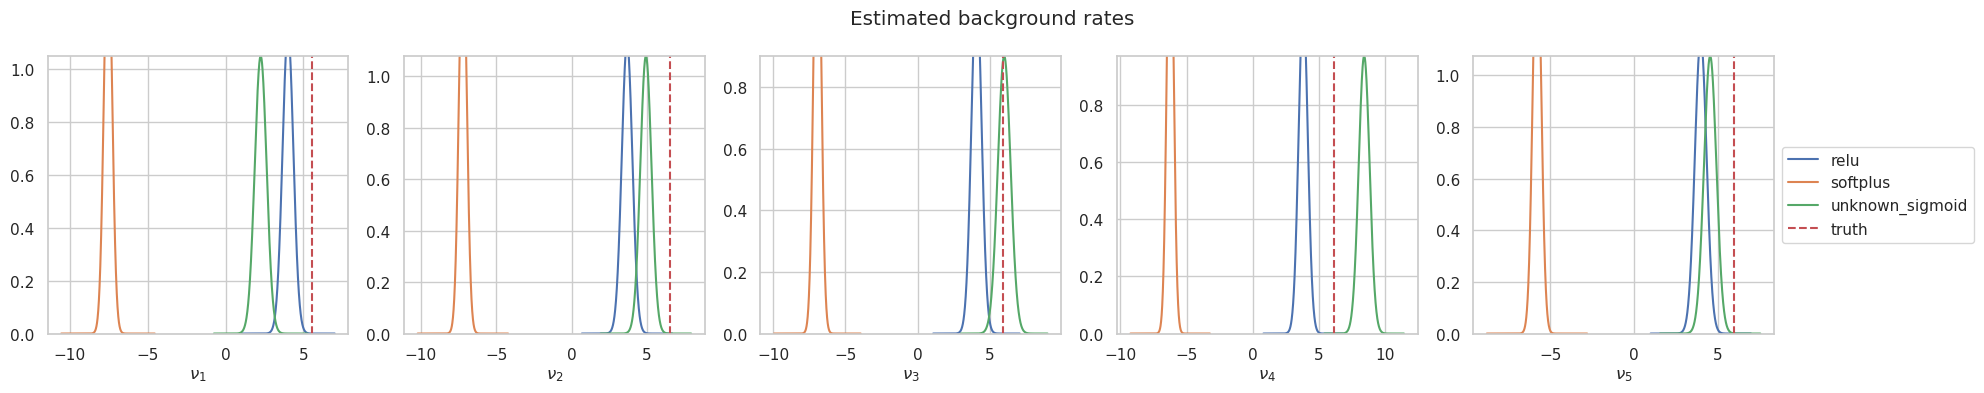

In [33]:
# Estimation of the parameters
# background rates
n_max = 5
fig, ax = plt.subplots(1, n_max, figsize=(4* n_max,4))
plt.suptitle("Estimated background rates")
for i in range(n_max):
    for j in range(len(config)):
        T = config[j]["T"]
        mean_nu = np.array(mean_estimator[j][0])
        base_activation = np.array(config[j]["base_activation"])
        cov = np.array(cov_estimator[j][i])
        if n_max == 1:
            a = ax
        else:
            a = ax[i]
        x = np.linspace(mean_nu[i] -3.0, mean_nu[i]+3.0, 1000)
        q1_nu = norm.pdf(x, loc=mean_nu[i], scale=np.sqrt(cov[0,0]))
        a.plot(x, q1_nu, label=f'{list_links[j]}')
        ymax = np.max(q1_nu)
        a.set_ylim(0,ymax)
        a.grid(visible=True)
        a.set_xlabel(rf'$\nu_{i+1}$')
        if j > len(config)-2:
            a.vlines(x=base_activation[i], ymin=0, ymax=ymax, linestyles='dashed', label='truth', color='r')
    if i>n_max-2:
        a.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f"/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/results/figures/estimated_nu_D{number_of_dimensions}_{scen}_mispecified.pdf")

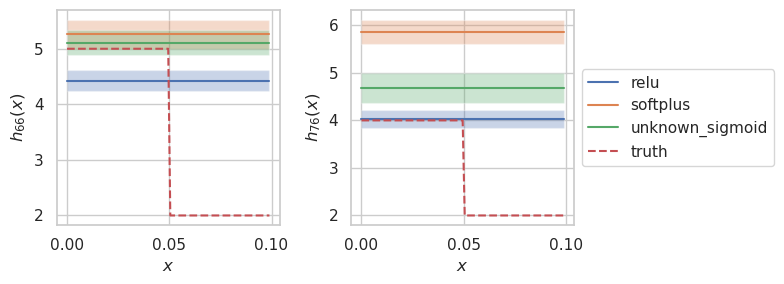

In [34]:
# Plot background rate and all non-null functions at one dimension in the "MAP" model
dim = 5
fig, ax = plt.subplots(1, 2, figsize=(8,3))
for j in range(2):
    a = ax[j]
    for i in range(len(config)):
        mean_nu, mean_weight, cov = mean_estimator[i][0], mean_estimator[i][1], cov_estimator[i]
        cf = config[i]
        n_basis_true = cf['n_bas']
        w_true = np.array(cf['weights'])
        base_activation = np.array(cf["base_activation"])
        T = cf["T"]

        mean_weight = np.array(mean_weight).reshape(number_of_dimensions, number_of_dimensions, -1)
        cov = np.array(cov)

        bins_true = np.linspace(0, cf["A"], num=cf['n_bas']+1)
        x = np.linspace(0, cf["A"], num=100)[:-1]
        y_true = np.digitize(x, bins=bins_true) - 1

        n_bins = sel_models[i][1]
        #print(n_bins)
        bins = np.linspace(0, cf["A"], num=n_bins+1)
        y = np.digitize(x, bins=bins) - 1

        std_w = np.sqrt(np.diag(cov[dim]))[1+(dim+j)*n_bins:1+(dim+j+1)*n_bins]
        a.plot(x, mean_weight[dim,dim+j][y], label=f"{list_links[i]}")
        a.fill_between(x, (mean_weight[dim,dim+j] - 2*std_w)[y], (mean_weight[dim,dim+j] + 2*std_w)[y], alpha=0.3)

        a.set_xlabel(r'$x$')
        a.grid(b=True)
        id_latex=(dim+j+1)*10+(dim+1)
        a.set_ylabel(r'$h_{{{}}}(x)$'.format(id_latex))
    if i==len(config)-1:
        a.plot(x, w_true[dim][dim+j][y_true], label='truth', linestyle='dashed')
a.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/results/figures/estimated_h_D{number_of_dimensions}_{scen}_mispecified.pdf',
    bbox_inches='tight')